# LFD Homework 5

Fifth week homework for the "Learning from Data" course offerd by [Caltech on edX](https://courses.edx.org/courses/course-v1:CaltechX+CS1156x+3T2017). Note that this notebook does not contain *all* solutions; it showcases solutions to those problems that require programming / simulation (and omits pen and paper problems).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

%matplotlib notebook

## Gradient Descent (P5 - P7)

The nonlinear error surface $E$ is defined as

$$
E(u,v) = \left(u \mathrm{e}^v - 2v\mathrm{e}^{-u}\right)^2
$$

Now we want to minimize the error using gradient descent in the $uv$ space with a learning rate of $\eta = 0.1$. For some vector $w = (u, v)$, the gradient descent algorithm uses the update rule

$$
w(t+1) = w(t) - \eta \nabla_w E(w(t))
$$

where in this case

$$
\nabla_w E(w) = \begin{pmatrix}\frac{\partial E(u, v)}{\partial u} \\ \frac{\partial E(u, v)}{\partial v} \end{pmatrix} = \begin{pmatrix} 2 \left(\mathrm{e}^v + 2v\mathrm{e}^{-u}\right) \left(u \mathrm{e}^v - 2v\mathrm{e}^{-u}\right) \\ 2 \left(u\mathrm{e}^v - 2\mathrm{e}^{-u}\right) \left(u \mathrm{e}^v - 2v\mathrm{e}^{-u}\right) \end{pmatrix}
$$

### P5

How many iterations does it take for the error $E(u, v)$ to fall below $10^{-14}$ for the first time?

In [2]:
def E(w):
    u, v = w
    return (u*np.exp(v) - 2*v*np.exp(-u))**2


def nabla_E(w):
    u, v = w
    return np.array([
        2 * (np.exp(v) + 2*v*np.exp(-u)) * (u*np.exp(v) - 2*v*np.exp(-u)),
        2 * (u*np.exp(v) - 2*np.exp(-u)) * (u*np.exp(v) - 2*v*np.exp(-u))
    ])


def gd(w, E, nabla_E, eta=0.1, max_iter=1e6, target_error=1e-14):
    ''' Simple gradient descent descent implementation.'''
    
    for i in range(int(max_iter)):
        w -= eta * nabla_E(w)
        if E(w) < target_error: break
    
    return w, i+1, E(w)


w = np.array([1., 1.])
w_final, iterations, E_final = gd(w, E, nabla_E)

print('Results\n-------\n(u, v)\t\t= ({:.3f}, {:.3f})\niterations\t= {}\nE_final\t\t= {:.3E}'
      .format(*w_final, iterations, E_final)
)

Results
-------
(u, v)		= (0.045, 0.024)
iterations	= 10
E_final		= 1.209E-15


### P 6

For the final results, what is the closest value (in Euclidean distance) among the given choices?

In [3]:
choices = np.array([
    [1., .713, .016, -.083, .045],
    [1., .045, .112,  .029, .024]
])
w_final = w_final.reshape(-1,1)

distances = np.sum((choices - w_final)**2, axis=0)
idx = np.argmin(distances)
print('closest point: ({:.3f}, {:.3f})'.format(*choices[:, idx]))

closest point: (0.045, 0.024)


### P 7

Compare the performance of gradient descent to "coordinate descent" where in each iteration, we have two distinct steps along the two coordinates. Using the same learning rate of $\eta = 0.1$, what will the error $E(u, v)$ be closest to after 15 full iterations (30 steps)?

In [4]:
def cd(w, E, nabla_E, eta=0.1, max_iter=1e6, target_error=1e-21):
    ''' Simple gradient descent descent implementation.'''
    
    for i in range(int(max_iter)):
        w[0] -= eta * nabla_E(w)[0]
        w[1] -= eta * nabla_E(w)[1]
        if E(w) < target_error: break
    
    return w, i+1, E(w)


w = np.array([1., 1.])
w_final, iterations, E_final = cd(w, E, nabla_E, max_iter=30)

print('Results\n-------\n(u, v)\t\t= ({:.3f}, {:.3f})\niterations\t= {}\nE_final\t\t= {:.3E}'
      .format(*w_final, iterations, E_final)
)

Results
-------
(u, v)		= (6.260, -3.152)
iterations	= 30
E_final		= 7.822E-02


## Logistic Regression (P8 - P9)

Let $\mathcal{X} = [-1, 1]^2,~d=2$ and $f: \mathcal{X} \mapsto \mathcal{Y}$ be a 1/0 probability function of $x$ (deterministic). In order to generate such an $f$, we picks two points from $\mathcal{X}$ at random (uniform) and use the line through these points as decision boundary. This setup is similar to the data required in `HW1` and `HW2`, so we can re-use the functions generating the data and adapt them according to problem specification:

In [5]:
def generate_data(N = 10, f=None):
    ''' Generates linear target function f and labeled, linearly separable test data generated by f.'''
    
    if f is None:
        # choose two random points p1, p2 and compute a vector p orthogonal to their difference
        p1, p2 = (np.random.rand(2,2) - 0.5) * 2.
        p = np.array([1, -(p2 - p1)[0]/(p2 - p1)[1]])
        p /= np.linalg.norm(p)
    
        f = lambda x: (np.sign((x - p1) @ p).reshape(-1,1) > 0).astype(float)
        f.db = lambda x: (p2[1] - p1[1])/(p2[0] - p1[0]) * (x - p1[0]) + p1[1]
    
    # generate uniformely distributed data points and apply classifier to label them
    X = (np.random.rand(N, 2) - 0.5) * 2
    Y = f(X)
    Y[Y == 0.] = -1
    
    return X,Y,f


def plot_data(X, Y, db = None):
    ''' Plots two dimensional, linearly separable data from the interval [-1, 1] and the optional decision boundary db.'''
    
    plt.figure()
    
    pos_examples = X[(Y == 1).reshape(-1)]
    neg_examples = X[(Y == -1).reshape(-1)]
    neu_examples = X[(Y == 0).reshape(-1)]
    
    # plot the three groups of examples
    plt.scatter(pos_examples[:,0], pos_examples[:,1], color='steelblue', marker='+')
    plt.scatter(neg_examples[:,0], neg_examples[:,1], color='red', marker='o')
    plt.scatter(neu_examples[:,0], neu_examples[:,1], color='black', marker='o')
    
    # plot the decision boundary if provided
    if db is not None:
        x = np.arange(-1., 1., 0.01)
        plt.plot(x, db(x), c='red', ls='dashed', lw=1.)
    
    plt.grid(alpha=.3)
    plt.gca().set_xlim(-1, 1)
    plt.gca().set_ylim(-1, 1)

Now the task is to pick $N = 100$ training points:

<IPython.core.display.Javascript object>


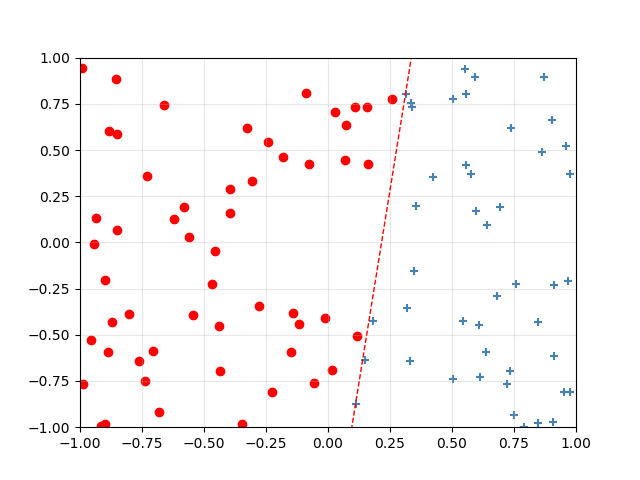

In [7]:
X, Y, f = generate_data(100)
plot_data(X, Y, f.db)

On this training data, we want to perform logistic regression with stochastic gradient descent (SGD) to elect a hypothesis $g$. Subsequently, we want to estimate the out of sample cross entropy error $E_{out}$ of that hypothesis $g$.

In [8]:
@nb.jit([nb.float64[:](nb.float64[:], nb.float64[:], nb.float64[:])], nopython=True)
def nabla_e(w, x, y):
    z = -y * x / (1. + np.exp(y * np.dot(w, x)))
    return z


@nb.jit(nopython=True)
def gd(w, X, Y, eta=.01, epochs=1000, target_delta=.01):
    N, d = X.shape
    idx = np.arange(N)
    for t in range(epochs):
        np.random.shuffle(idx)
        w_tm1 = w.copy()
        
        for t_b in range(N):
            idx_b = idx[t_b]
            x_b, y_b = X[idx_b], Y[idx_b]            
            w -= eta * nabla_e(w, x_b, y_b)
    
        delta = w_tm1 - w
        if np.sqrt(delta @ delta) < target_delta: break
            
    return w, t


class LR_SGD:
    ''' Logistic regression classifier, trained with stochastic gradient descent.'''
    
    def __init__(self, X, Y, eta=.01, max_iter=1e5, target_delta=.01, add_intercept=True):       
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        # initialization
        w = np.zeros(d+1) if add_intercept else np.zeros(d)
        
        self.w, self.epochs = gd(w, X, Y)
        self.w = self.w.reshape(-1, 1)
        self.E_in = self.E(X, Y, add_intercept=False)
    

    def __call__(self, X, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        return 1. / (1. + np.exp(-X @ self.w)).reshape(-1,1)

    
    def E(self, X, Y, add_intercept=True):
        ''' Computes the cross-entropy error on the examples provided.'''      
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
            
        E_CE = np.sum(np.log(1. + np.exp(-Y * (X @ self.w)))) / N
        return E_CE

What is the closest estimate for $E_{out}$ among the given choices? How many epochs does it take on average for the computation to converge to a stable solution?

In [9]:
def experiment_lrsgd(N=100, N_test=1000, repeat=1000, f=None, gen=generate_data):
    data = []

    for i in range(repeat):
        # generate test data and function
        X, Y, f = gen(N, f)
        
        # train a linear regression based classifier and obtain its E_in
        g = LR_SGD(X, Y)
        E_in, epochs = g.E_in, g.epochs
        
        # obtain the out of sample error rate using the generated function f
        X_test, Y_test, _ = gen(N_test, f)
        E_out = g.E(X_test, Y_test)
    
        data.append((E_in, E_out, epochs))
        if i%100 == 0:
            print('experiment (run={}): E_in={:.3f} / E_out={:.3f} / epochs={}'.format(i, E_in, E_out, epochs))
    
    results = np.array(data)
    print('\nAverage Errors\n--------------\nE_in\t= {:.3f}\nE_out\t= {:.3f}\n\nAverage Epochs\n--------------\nepochs=\t{:.3f}'.format(*np.mean(results, axis=0)))
    return results


experiment_lrsgd();

experiment (run=0): E_in=0.111 / E_out=0.103 / epochs=465
experiment (run=100): E_in=0.113 / E_out=0.117 / epochs=318
experiment (run=200): E_in=0.112 / E_out=0.113 / epochs=367
experiment (run=300): E_in=0.097 / E_out=0.095 / epochs=385
experiment (run=400): E_in=0.118 / E_out=0.102 / epochs=388
experiment (run=500): E_in=0.073 / E_out=0.113 / epochs=315
experiment (run=600): E_in=0.087 / E_out=0.122 / epochs=331
experiment (run=700): E_in=0.093 / E_out=0.144 / epochs=303
experiment (run=800): E_in=0.077 / E_out=0.117 / epochs=369
experiment (run=900): E_in=0.116 / E_out=0.117 / epochs=331

Average Errors
--------------
E_in	= 0.100
E_out	= 0.113

Average Epochs
--------------
epochs=	350.954
